# HIV-Inhibiting Molecule Classification using Deep Learning

## Roadmap

1. Introduce the problem and the dataset
2. Import libraries
3. Load the data
4. Visualize the data
5. Visualize the metrics that need to be achieved
6. Try logistic regression
7. Try a simple neural network
8. Try a simple GCN
9. Try a simple GAT
10. Try playing with convolution and aggregation styles

## Install Instructions

In [ ]:
# Assuming you have a conda env already set up
!pip install -r requirements.txt

In [ ]:
# This next install depends on whether you have a cpu or gpu. If you have a gpu, you can install the gpu version of torch_geometric:
!pip install torch_scatter -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
# If you have a cpu, comment out the above line and run the following command:
#!pip install torch_scatter -f https://data.pyg.org/whl/torch-2.3.0+cpu.html

## Intro

The nodes in the graph have features given by `graph.x`:
- atomic_num: the atomic number of the atom
- chirality: the chirality of the atom
- degree: the degree of the atom
- formal_charge: the formal charge of the atom
- num_h: the number of hydrogens of the atom
- num_rad_e: the number of radical electrons of the atom
- hybridization: the hybridization of the atom
- is_aromatic: whether the atom is aromatic
- is_in_ring: whether the atom is in a ring

The edges in the graph have features given by `graph.edge_attr`: 
- bond_type: the type of the bond
- bond_stereo: the stereo of the bond
- is_conjugated: whether the bond is conjugated

The graph has just one "feature", which is a binary label indicating whether the molecule is an HIV-inhibitor or not:
- `graph.y`: whether the molecule is an HIV-inhibitor

## Load the data

In [1]:
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader

dataset = PygGraphPropPredDataset(name = "ogbg-molhiv") 

split_idx = dataset.get_idx_split() 
train_pyg_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True)
valid_pyg_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False)
test_pyg_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False)

/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Visualize the data

In [2]:
example_graph = valid_pyg_loader.dataset[0]
print(example_graph)

Data(edge_index=[2, 52], edge_attr=[52, 3], x=[23, 9], y=[1, 1], num_nodes=23)


In [3]:
import networkx as nx
from torch_geometric.utils import to_networkx

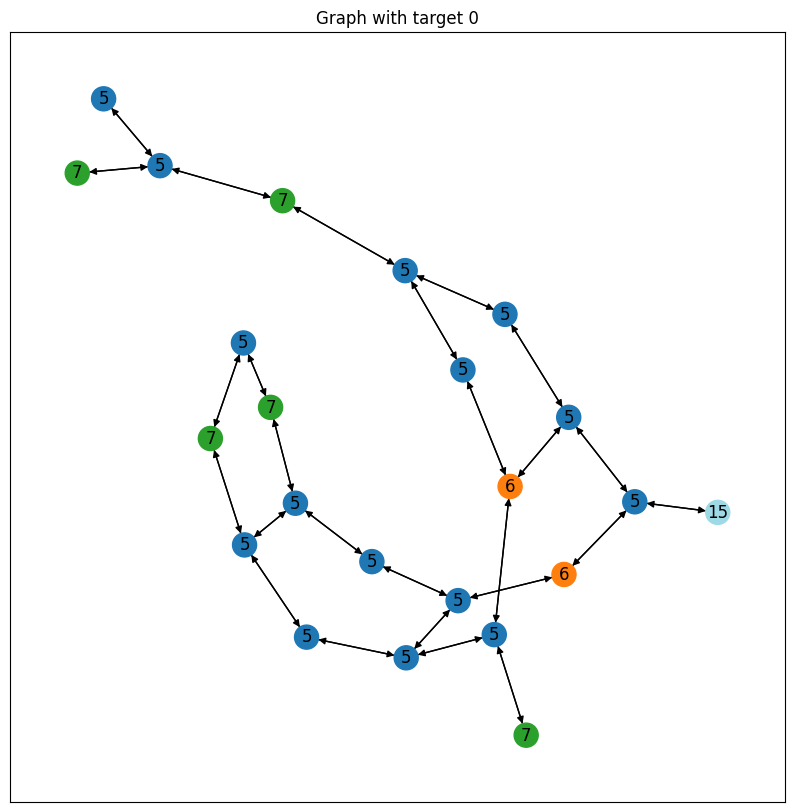

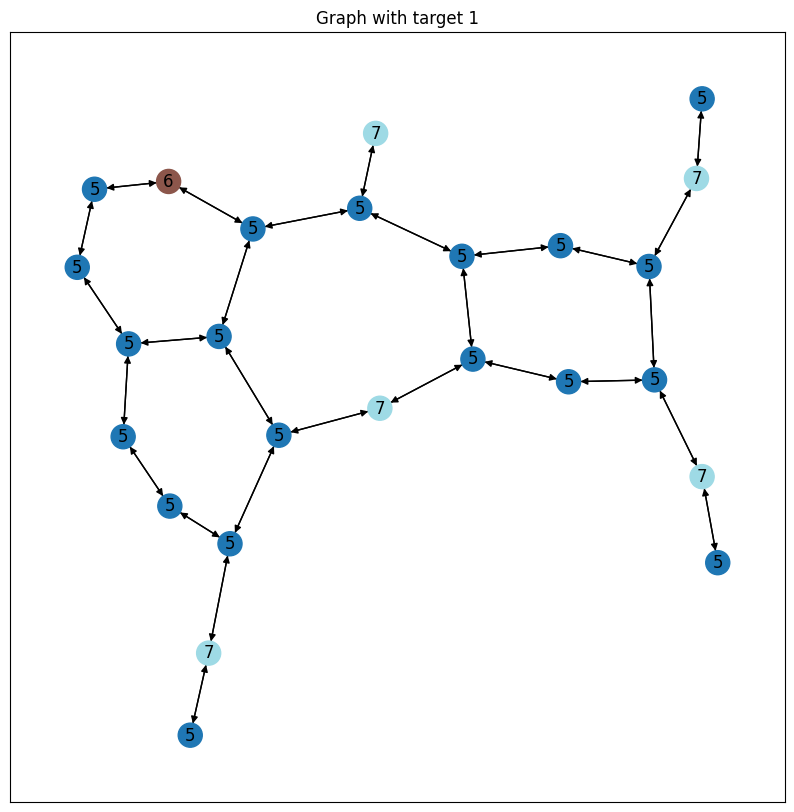

In [4]:
import matplotlib.pyplot as plt
# Function to visualize graph based on target value
def visualize_graph_with_target(loader, target_value):
    for graph in loader.dataset:
        if graph.y.item() == target_value:
            plt.figure(figsize=(10, 10))
            atomic_number = graph.x[:, 0].numpy()
            graph_networkx = to_networkx(graph.clone())
            pos = nx.spring_layout(graph_networkx)
            nx.draw_networkx(graph_networkx, pos, labels=dict(zip(range(len(atomic_number)), atomic_number)), node_size=300, node_color=atomic_number, cmap="tab20")
            plt.title(f"Graph with target {graph.y.item()}")
            plt.show()
            break

# Visualize graph with target 0
visualize_graph_with_target(valid_pyg_loader, 0)

# Visualize graph with target 1
visualize_graph_with_target(valid_pyg_loader, 1)


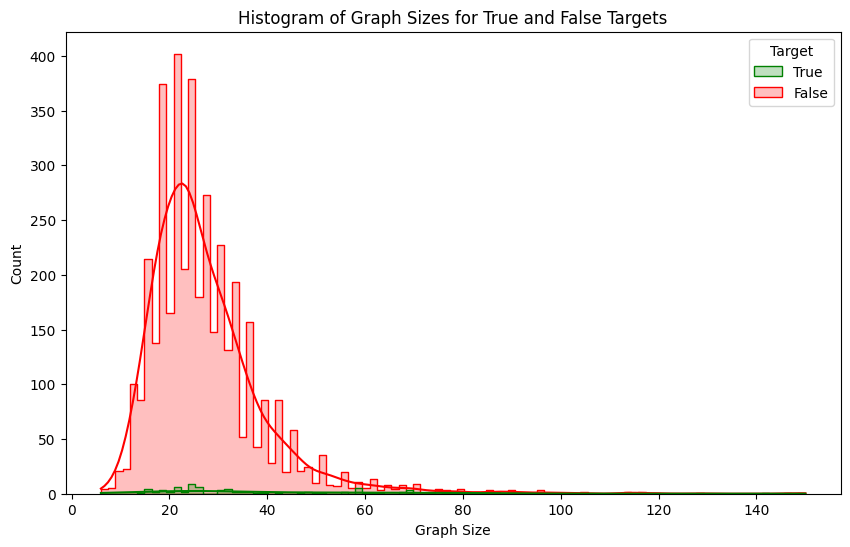

In [5]:
# Plot histograms of graph sizes for true and false graphs
import seaborn as sns
import pandas as pd

def plot_histograms_of_graph_sizes(loader):
    true_sizes = []
    false_sizes = []
    for graph in loader.dataset:
        if graph.y.item() == 1:
            true_sizes.append(graph.num_nodes)
        else:
            false_sizes.append(graph.num_nodes)
    
    # Create a DataFrame to facilitate plotting with seaborn
    data_true = pd.DataFrame({'Size': true_sizes, 'Target': 'True'})
    data_false = pd.DataFrame({'Size': false_sizes, 'Target': 'False'})
    data = pd.concat([data_true, data_false])
    
    # Plotting the histograms
    plt.figure(figsize=(10, 6))
    sns.histplot(data, x='Size', hue='Target', element='step', kde=True, palette=['green', 'red'])
    plt.title('Histogram of Graph Sizes for True and False Targets')
    plt.xlabel('Graph Size')
    plt.ylabel('Count')
    plt.show()

plot_histograms_of_graph_sizes(valid_pyg_loader)


We see that the data is VERY imbalanced - most molecules are not useful for fighting HIV (as you might expect!). So we will need to be careful about how we evaluate our models. We can't simply use accuracy, as a model that always predicts "not an HIV-inhibitor" would be right 99% of the time!

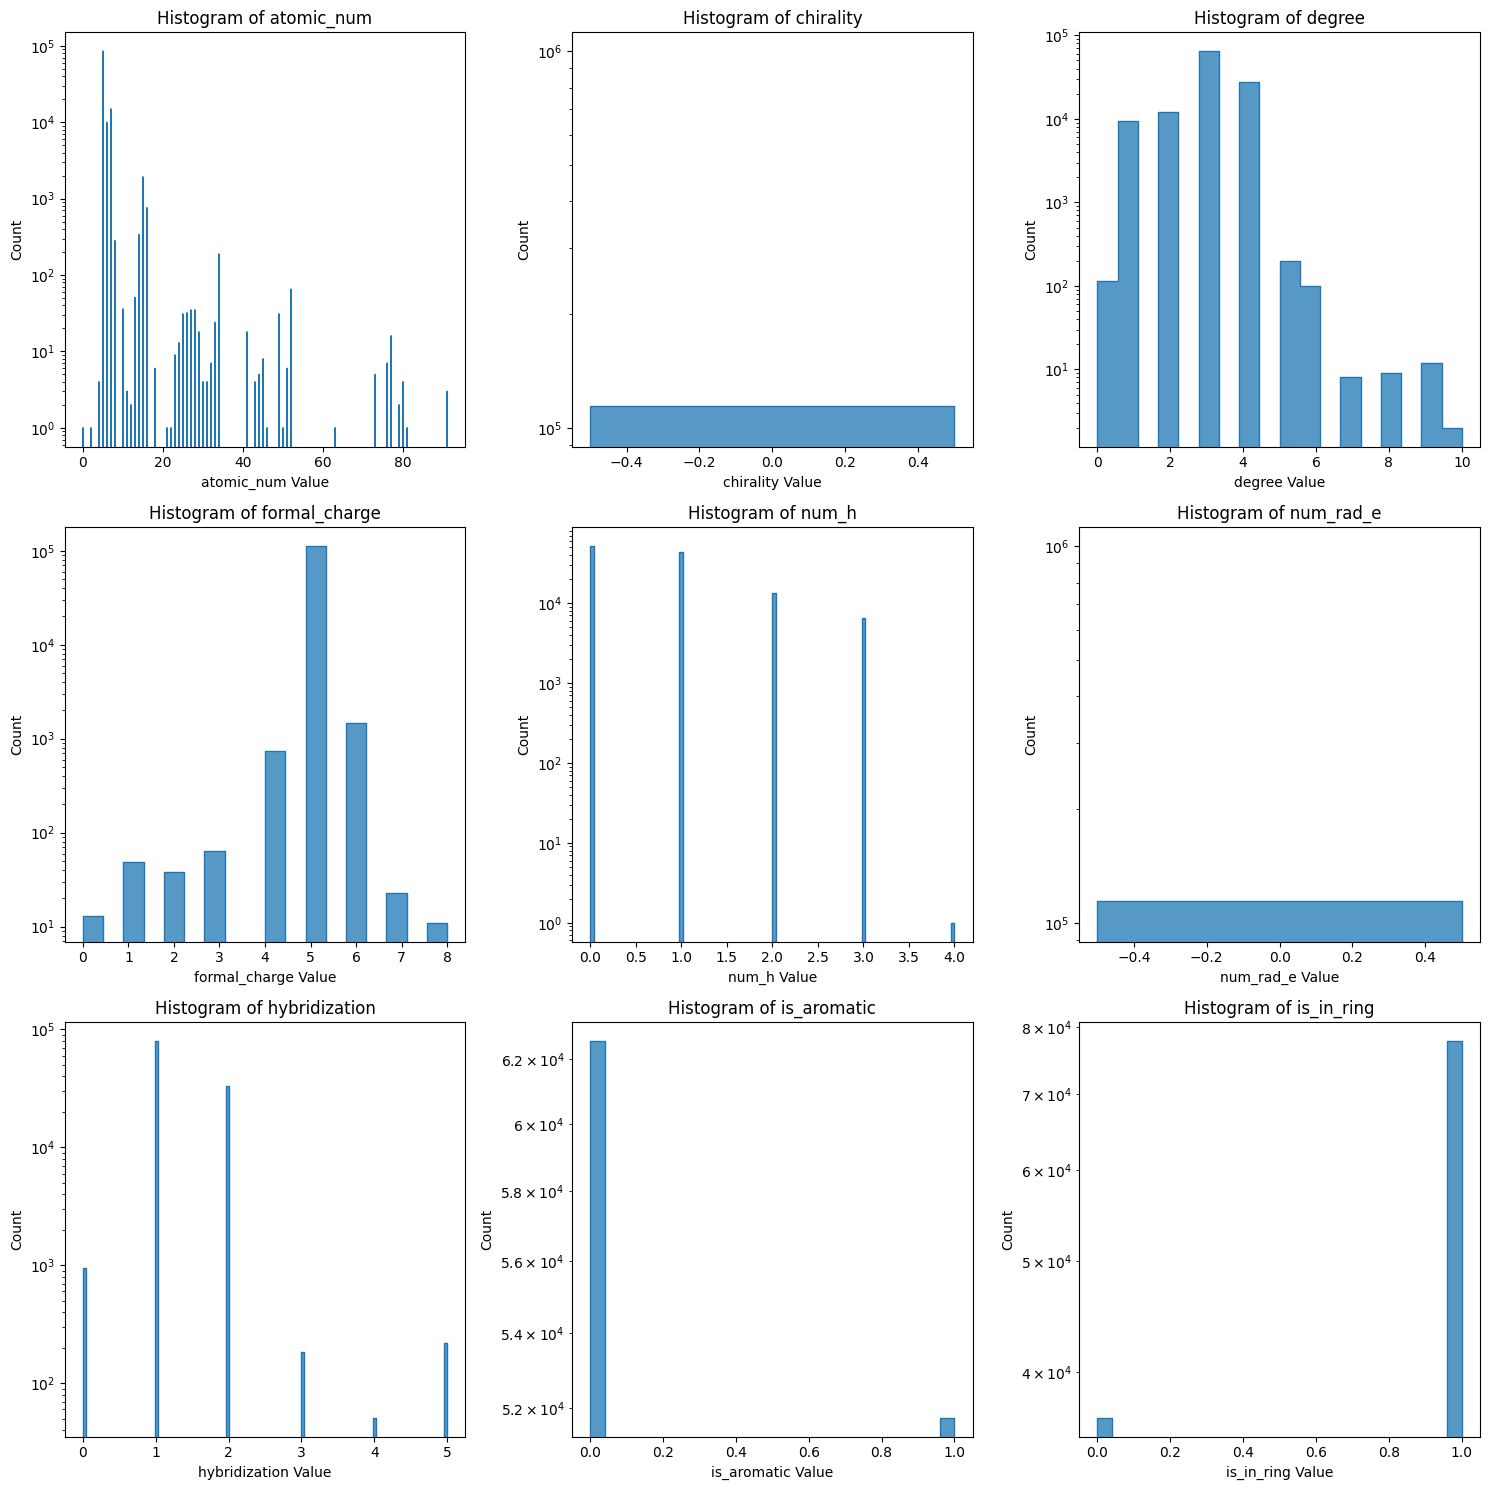

In [6]:
# Let's also histogram each of the node features, so we know what scales they are:
def plot_histograms_of_node_features(loader):
    feature_names = ['atomic_num', 'chirality', 'degree', 'formal_charge', 'num_h', 'num_rad_e', 'hybridization', 'is_aromatic', 'is_in_ring']
    num_features = len(feature_names)
    
    # Create a 3x3 subplot grid
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    
    for i in range(num_features):
        all_features = []
        for graph in loader.dataset:
            all_features.extend(graph.x[:, i].numpy())
        
        # Plot on the ith subplot
        sns.histplot(all_features, element='step', ax=axes[i])
        axes[i].set_title(f'Histogram of {feature_names[i]}')
        axes[i].set_xlabel(f'{feature_names[i]} Value')
        axes[i].set_ylabel('Count')
        axes[i].set_yscale('log')  # Set y-axis scale to logarithmic
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

plot_histograms_of_node_features(valid_pyg_loader)


Overall, the data is all of a similar scale, so we don't need to be too worried about normalizing. Maybe we could take the log of the atomic number, and add that as a feature. But that's about it.

## Try Logistic Regression

Let's try the absolute most naive thing: Logistic regression. This will give us a baseline to compare against.
The first question is what is the input to our logistic regression. It's non-obvious, since we have two problems:
1. The input features are nodes in no obvious or particular order
2. The list of nodes is different from one graph to the next

So to make our first naive benchmark as simple as possible, let's take some simplifications to the dataset:
1. Let's sort the nodes from largest to smallest atomic number
2. Let's take the first 10 sorted nodes in each graph, and pad with zeros if there are fewer than 20 nodes

### Sort the nodes by atomic number

In [12]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Function to preprocess and flatten graph data
def preprocess_data(loader):
    X, y = [], []
    for data in loader.dataset:
        # Sort nodes by atomic number in descending order
        node_features = data.x
        sorted_nodes = node_features[node_features[:, 0].argsort(descending=True)]
        
        # Add log of the first feature (atomic number) as a new feature
        log_feature = np.log(sorted_nodes[:, 0] + 1).reshape(-1, 1)  # Adding 1 to avoid log(0)
        sorted_nodes = np.hstack([sorted_nodes, log_feature])
        
        # Select the first N nodes
        num_nodes = 20

        # Select the first 20 nodes, pad if necessary
        if len(sorted_nodes) < num_nodes:
            padding = np.zeros((num_nodes - len(sorted_nodes), sorted_nodes.shape[1]))
            sorted_nodes = np.vstack([sorted_nodes, padding])
        elif len(sorted_nodes) > num_nodes:
            sorted_nodes = sorted_nodes[:num_nodes]
        
        # Flatten the node features to create a single feature vector
        flat_features = sorted_nodes.flatten()
        X.append(flat_features)
        y.append(data.y.item())
    
    return np.array(X), np.array(y)

In [13]:
# Preprocess the data
X_train, y_train = preprocess_data(train_pyg_loader)
X_valid, y_valid = preprocess_data(valid_pyg_loader)
X_test, y_test = preprocess_data(test_pyg_loader)

/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.9795769511305616
Validation AUC: 0.7061272168332353
Test Accuracy: 0.9683929005592026
Test AUC: 0.6809150427779601


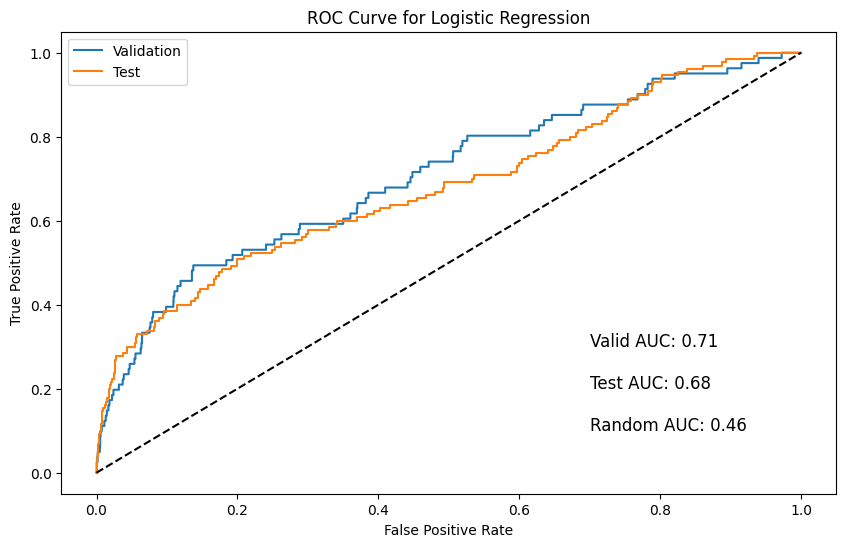

In [14]:
# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model
y_pred_valid = model.predict(X_valid)
y_pred_test = model.predict(X_test)
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
valid_auc = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
test_accuracy = accuracy_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Validation Accuracy: {valid_accuracy}")
print(f"Validation AUC: {valid_auc}")

print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

# Also get the ROC AUC for a random classifier
random_preds = np.random.rand(len(y_test))
random_auc = roc_auc_score(y_test, random_preds)

fpr_valid, tpr_valid, _ = roc_curve(y_valid, model.predict_proba(X_valid)[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr_valid, tpr_valid, label='Validation')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.text(0.7, 0.3, f'Valid AUC: {valid_auc:.2f}', fontsize=12)
plt.text(0.7, 0.2, f'Test AUC: {test_auc:.2f}', fontsize=12)
plt.text(0.7, 0.1, f'Random AUC: {random_auc:.2f}', fontsize=12)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.show()



Okay, we're better than a coin flip. Not bad for 3 seconds of work. But we have a long way to go if we want to get onto the OGB Leaderboard for this benchmark:
![OGB Leaderboard](img/mol_hiv_leaderboard.png)

So let's try something more sophisticated...


## Try a BDT

Validation AUC (BDT): 0.7357176538310797
Test AUC (BDT): 0.7265851020684061


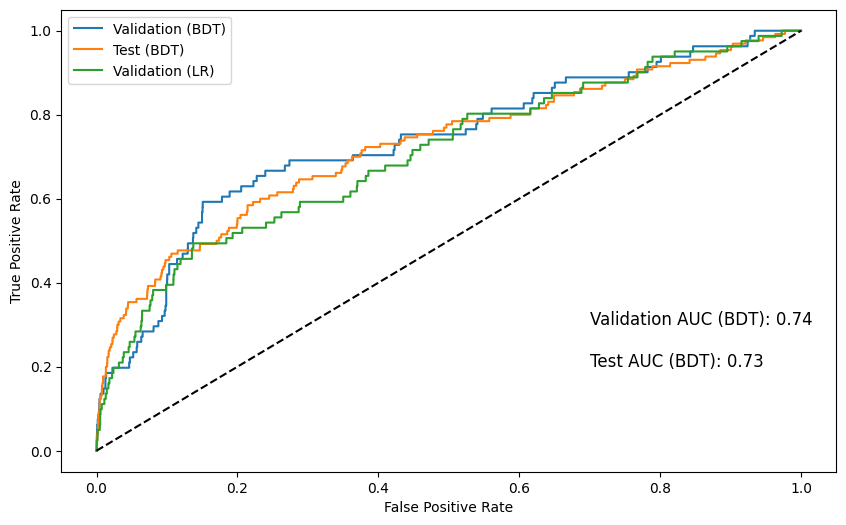

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting model
bdt_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
bdt_model.fit(X_train, y_train)

# Evaluate the model using AUC
y_prob_valid_bdt = bdt_model.predict_proba(X_valid)[:, 1]  # Get probabilities for the positive class
y_prob_test_bdt = bdt_model.predict_proba(X_test)[:, 1]    # Get probabilities for the positive class

valid_auc_bdt = roc_auc_score(y_valid, y_prob_valid_bdt)
test_auc_bdt = roc_auc_score(y_test, y_prob_test_bdt)

print(f"Validation AUC (BDT): {valid_auc_bdt}")
print(f"Test AUC (BDT): {test_auc_bdt}")

# Plot ROC curve
fpr_valid_bdt, tpr_valid_bdt, _ = roc_curve(y_valid, y_prob_valid_bdt)
fpr_test_bdt, tpr_test_bdt, _ = roc_curve(y_test, y_prob_test_bdt)

plt.figure(figsize=(10, 6))
plt.plot(fpr_valid_bdt, tpr_valid_bdt, label='Validation (BDT)')
plt.plot(fpr_test_bdt, tpr_test_bdt, label='Test (BDT)')
plt.plot(fpr_valid, tpr_valid, label='Validation (LR)')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.text(0.7, 0.3, f'Validation AUC (BDT): {valid_auc_bdt:.2f}', fontsize=12)
plt.text(0.7, 0.2, f'Test AUC (BDT): {test_auc_bdt:.2f}', fontsize=12)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

Creeping up... but still a long way to go to an AUC of 0.84. Let's try a simple neural network next.

## Try a simple neural network

For this simple neural network, let's switch back to pytorch. In particular, let's use pytorch lightning to avoid boilerplate code. (If you haven't used pytorch or pytorch lightning before, you can think of pytorch = tensorboard, and pytorch lightning = keras). 

In [16]:
import lightning as lit
from lightning.pytorch.callbacks import Callback
from lightning.pytorch import Trainer
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from lightning.pytorch.loggers import CSVLogger  # Import CSVLogger
import numpy as np

def prepare_data_loaders(X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32):
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    valid_dataset = TensorDataset(torch.FloatTensor(X_valid), torch.FloatTensor(y_valid))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader, test_loader

def make_mlp(
    input_size,
    sizes,
    hidden_activation="ReLU",
    output_activation=None,
    layer_norm=False,
):
    """Construct an MLP with specified fully-connected layers."""
    hidden_activation = getattr(nn, hidden_activation)()
    output_activation = getattr(nn, output_activation)() if output_activation else None
    layers = []
    sizes = [input_size] + sizes

    # Add hidden layers
    for i in range(len(sizes) - 2):  # Change the range to stop before the last hidden layer
        layers.append(nn.Linear(sizes[i], sizes[i + 1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i + 1], elementwise_affine=False))
        layers.append(hidden_activation)

    # Add final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation:
        layers.append(output_activation)

    return nn.Sequential(*layers)

class BaseLitModel(lit.LightningModule):
    def __init__(self, lr=1e-3, weight_decay=0, lr_decay=0.95):
        super().__init__()

        self.criterion = nn.BCELoss()
        self.val_preds = []
        self.val_targets = []
        self.test_preds = []
        self.test_targets = []
        self.lr = lr
        self.weight_decay = weight_decay
        self.lr_decay = lr_decay

    def training_step(self, batch, batch_idx):
        y_hat, y = self.apply_model(batch)
        # Check if y needs to be unsqueezed
        if len(y.shape) == 1:
            y = y.unsqueeze(1)
        loss = self.criterion(y_hat, y.float())
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)  # Log on progress bar
        self.log('learning_rate', self.trainer.optimizers[0].param_groups[0]['lr'], on_step=False, on_epoch=True, prog_bar=True)  # Log current learning rate
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self.apply_model(batch)
        # Check if y needs to be unsqueezed
        if len(y.shape) == 1:
            y = y.unsqueeze(1)
        loss = self.criterion(y_hat, y.float())
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)  # Log on progress bar
        self.val_preds.extend(y_hat.view(-1).detach().cpu().numpy())
        self.val_targets.extend(y.view(-1).detach().cpu().numpy())
        return loss
    
    def test_step(self, batch, batch_idx):
        y_hat, y = self.apply_model(batch)
        # Check if y needs to be unsqueezed
        if len(y.shape) == 1:
            y = y.unsqueeze(1)
        loss = self.criterion(y_hat, y.float())
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)  # Log on progress bar
        self.test_preds.extend(y_hat.view(-1).detach().cpu().numpy())
        self.test_targets.extend(y.view(-1).detach().cpu().numpy())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: self.lr_decay ** epoch),
            'name': 'lambda_decay'
        }
        return [optimizer], [lr_scheduler]

class AUCCallback(Callback):
    def on_validation_epoch_end(self, trainer, pl_module):
        val_auc = roc_auc_score(pl_module.val_targets, pl_module.val_preds)
        pl_module.log("val_auc", val_auc, prog_bar=True)  # Log on progress bar
        pl_module.val_preds = []
        pl_module.val_targets = []

    def on_test_epoch_end(self, trainer, pl_module):
        test_auc = roc_auc_score(pl_module.test_targets, pl_module.test_preds)
        pl_module.log("test_auc", test_auc, prog_bar=True)  # Log on progress bar
        pl_module.test_preds = []
        pl_module.test_targets = []

# Prepare data loaders
def prepare_data_loaders(X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32):
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    valid_dataset = TensorDataset(torch.FloatTensor(X_valid), torch.FloatTensor(y_valid))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader, test_loader

In [17]:
class SimpleMLP(BaseLitModel):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__(lr=1e-3, weight_decay=0, lr_decay=0.90)
        self.model = make_mlp(input_size, 
                              [hidden_size]*3 + [output_size],
                              hidden_activation="ReLU", 
                              layer_norm=True,
                              output_activation="Sigmoid")

    def forward(self, x):
        return self.model(x)

    def apply_model(self, batch):
        x, y = batch
        return self(x), y
        
# Data loaders
train_loader, valid_loader, test_loader = prepare_data_loaders(X_train, y_train, X_valid, y_valid, X_test, y_test)

# Initialize the model
input_size = train_loader.dataset[0][0].shape[0]  # Adjust input size for the new feature
hidden_size = 64  # You can tune this parameter
output_size = 1
model = SimpleMLP(input_size, hidden_size, output_size)

# Train the model
auc_callback = AUCCallback()
csv_logger = CSVLogger('lightning_logs', name='mlp_model')  # Initialize CSVLogger
trainer = Trainer(max_epochs=10, accelerator="gpu", callbacks=[auc_callback], logger=csv_logger)  # Add logger to Trainer
trainer.fit(model, train_loader, valid_loader)

/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/d/danieltm/.conda/envs/appml/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | c

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 1029/1029 [00:06<00:00, 168.49it/s, v_num=23, val_loss=0.0978, val_auc=0.711, train_loss=0.143, learning_rate=0.000387]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1029/1029 [00:06<00:00, 168.13it/s, v_num=23, val_loss=0.0978, val_auc=0.711, train_loss=0.143, learning_rate=0.000387]


In [18]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

def find_latest_directory(base_path):
    list_of_files = glob.glob(f'{base_path}/version_*')
    latest_dir = max(list_of_files, key=os.path.getmtime)
    return latest_dir

def plot_metrics(directory, model_name):
    metrics_file = os.path.join(directory, 'metrics.csv')
    metrics_df = pd.read_csv(metrics_file)
    train_loss_df = metrics_df[metrics_df['train_loss'].notna()]
    val_loss_df = metrics_df[metrics_df['val_loss'].notna()]
    val_auc_df = metrics_df[metrics_df['val_auc'].notna()]
    learning_rate_df = metrics_df[metrics_df['learning_rate'].notna()]  # Extract learning rate data

    plt.figure(figsize=(16, 4))  # Adjusted figure size to accommodate new subplot
    plt.subplot(1, 4, 1)
    plt.plot(train_loss_df['step'], train_loss_df['train_loss'], label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.xscale('log')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(val_loss_df['epoch'], val_loss_df['val_loss'], label='Validation Loss')
    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.xscale('log')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(val_auc_df['epoch'], val_auc_df['val_auc'], label='Validation AUC')
    plt.title('Validation AUC Over Epochs')
    plt.xlabel('Step')
    plt.ylabel('AUC')
    plt.xscale('log')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(learning_rate_df['epoch'], learning_rate_df['learning_rate'], label='Learning Rate')
    plt.title('Learning Rate Over Epochs')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.xscale('log')
    plt.legend()

    plt.tight_layout()
    plt.show()

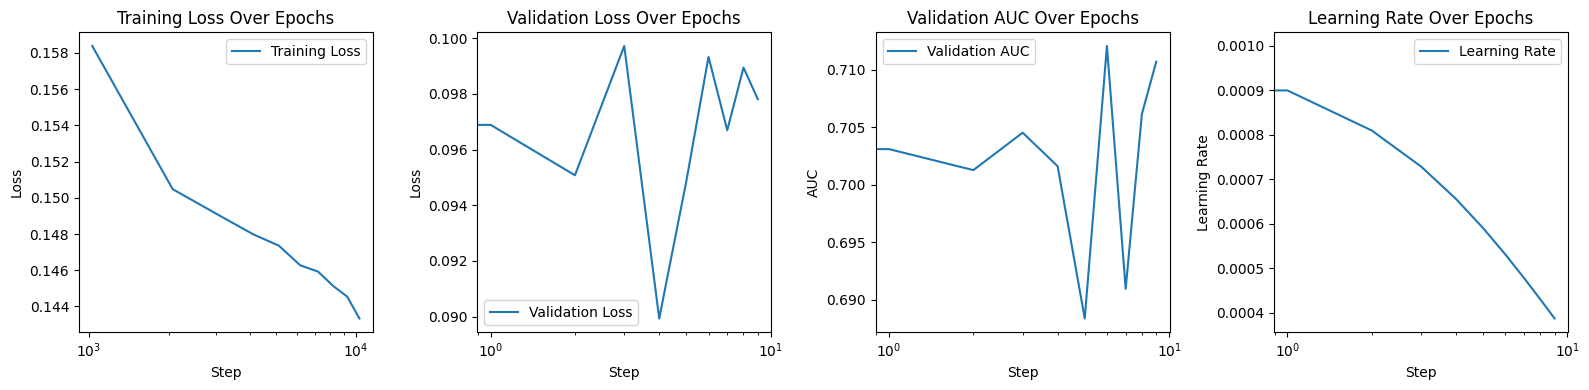

In [19]:
base_path = 'lightning_logs/mlp_model'
latest_dir = find_latest_directory(base_path)
plot_metrics(latest_dir, 'MLP Model')

## Interaction Network

So we're struggling to beat the BDT - it's just too good at consuming tabular data. But we have a secret weapon: the graph structure! Let's try a simple graph convolution network. We will use the industry-standard PyG ("Pytorch Geometric") library for this, with its built-in GCN implementation. But first, let's try to code up a graph neural network from scratch.

In [30]:
import torch
from torch_scatter import scatter_mean, scatter_add
from torch import nn

class InteractionGNN(BaseLitModel):
    def __init__(self, hparams):
        super(InteractionGNN, self).__init__(lr=hparams['lr'], weight_decay=hparams['weight_decay'], lr_decay=hparams['lr_decay'])

        # Node and Edge Networks
        self.input_node_network = make_mlp(
            input_size=hparams['input_size'],
            sizes=[hparams['hidden_size']] * 2,
            layer_norm=True,
            hidden_activation="ReLU"
        )
        self.node_network = make_mlp(
            input_size=hparams['hidden_size'],
            sizes=[hparams['hidden_size']] * 2,
            layer_norm=True,
            hidden_activation="ReLU"
        )
        self.edge_network = make_mlp(
            input_size=2 * hparams['hidden_size'],
            sizes=[hparams['hidden_size']] * 2,
            layer_norm=True,
            hidden_activation="ReLU"
        )
        self.output_network = make_mlp(
            input_size=hparams['hidden_size'],
            sizes=[hparams['output_size']],
            layer_norm=True,
            hidden_activation="ReLU",
            output_activation="Sigmoid"
        )
        self.num_graph_iters = hparams['num_graph_iters']

        self.aggregation = scatter_add

    def forward(self, graph):
        x, edge_index = graph.x.float(), graph.edge_index
        start, end = edge_index
        x = self.input_node_network(x)

        for _ in range(self.num_graph_iters):
            # Save the input to the iteration for the skip connection
            x_skip = x

            # Edge features update
            e = self.message_passing(x, start, end)

            # Message passing
            x = self.aggregation(e, end, dim=0, dim_size=x.size(0))  # Aggregating messages to target nodes

            x = scatter_add(e, end)

            # Node features update
            x = self.node_network(x)

            # Adding skip connection
            x = x + x_skip

        # Aggregate to graph level
        x = self.aggregation(x, graph.batch, dim=0)
        
        # Output layer
        out = self.output_network(x)

        return out
    
    def message_passing(self, x, start, end):
        
        edge_features = torch.cat([x[start], x[end]], dim=1)
        e = self.edge_network(edge_features)
        return e

    def apply_model(self, batch):
        return self(batch), batch.y

# Example usage
hparams = {
    'input_size': train_pyg_loader.dataset[0].x.shape[1],
    'hidden_size': 64,
    'output_size': 1,
    'lr': 3e-4,
    'weight_decay': 1e-5,
    'lr_decay': 0.97,
    'num_graph_iters': 3  # Number of graph iterations
}
model = InteractionGNN(hparams)

# Training setup remains the same
auc_callback = AUCCallback()
csv_logger = CSVLogger('lightning_logs', name='interaction_gnn_model')
trainer = Trainer(max_epochs=50, accelerator="gpu", callbacks=[auc_callback], logger=csv_logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(model, train_pyg_loader, valid_pyg_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type       | Params
--------------------------------------------------
0 | criterion          | BCELoss    | 0     
1 | input_node_network | Sequential | 4.8 K 
2 | node_network       | Sequential | 8.3 K 
3 | edge_network       | Sequential | 12.4 K
4 | output_network     | Sequential | 65    
--------------------------------------------------
25.6 K    Trainable params
0         Non-trainable params
25.6 K    Total params
0.102     Total estimated model params size (MB)


/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 1029/1029 [00:20<00:00, 50.67it/s, v_num=8, val_loss=0.0768, val_auc=0.788, train_loss=0.116, learning_rate=8.16e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1029/1029 [00:20<00:00, 50.65it/s, v_num=8, val_loss=0.0768, val_auc=0.788, train_loss=0.116, learning_rate=8.16e-5]


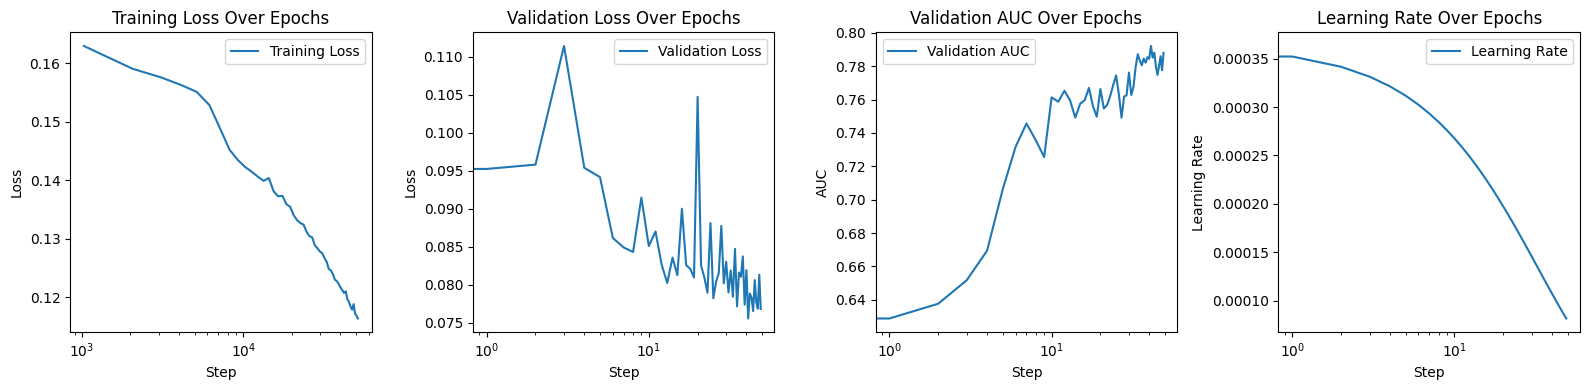

In [36]:
base_path = 'lightning_logs/interaction_gnn_model'
latest_dir = find_latest_directory(base_path)
plot_metrics(latest_dir, 'Interaction GNN Model')

In [38]:
# Test the model
trainer.test(model, test_pyg_loader)

/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/d/danieltm/.conda/envs/appml/lib/pytho ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 129/129 [00:01<00:00, 77.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_auc            0.7177253365516663
        test_loss           0.12509196996688843
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.12509196996688843, 'test_auc': 0.7177253365516663}]

In [58]:
from ogb.graphproppred import Evaluator

evaluator = Evaluator(name = 'ogbg-molhiv')

y_true = torch.cat([graph.y for graph in valid_pyg_loader]).numpy()
with torch.no_grad():
    y_pred = torch.cat([model(graph) for graph in valid_pyg_loader]).numpy()
input_dict = {"y_true": y_true, "y_pred": y_pred}
result_dict = evaluator.eval(input_dict)
print("VALIDATION RESULTS", result_dict)    

VALIDATION RESULTS {'rocauc': 0.7880015432098766}


In [59]:
from ogb.graphproppred import Evaluator

evaluator = Evaluator(name = 'ogbg-molhiv')

y_true = torch.cat([graph.y for graph in test_pyg_loader]).numpy()
with torch.no_grad():
    y_pred = torch.cat([model(graph) for graph in test_pyg_loader]).numpy()
input_dict = {"y_true": y_true, "y_pred": y_pred}
result_dict = evaluator.eval(input_dict)
print("TEST RESULTS", result_dict)    

TEST RESULTS {'rocauc': 0.7177253326638212}


# Try your own Torch Geometric model!

## Play with convolution and aggregation styles

We can tweak the convolution and aggregation styles to see if we can improve the performance of our model. E.g. we can try scatter max, scatter std, combine scatter operations, or we can try the MANY different convolutions available in PyG. 

## We can also try out-of-the-box convolutions from Pytorch Geometric

### Try a simple graph convolution network

In [ ]:
import lightning as lit
from lightning.pytorch.callbacks import Callback
from lightning.pytorch import Trainer
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch_geometric.nn import GCNConv, aggr
from lightning.pytorch.loggers import CSVLogger  # Import CSVLogger
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

class GCN(BaseLitModel):
    def __init__(self, input_size, hidden_size, output_size):
        super(GCN, self).__init__(lr=1e-3, weight_decay=0, lr_decay=0.90)
        self.node_network_1 = make_mlp(input_size, [hidden_size]*2, layer_norm=True, hidden_activation="ReLU")
        self.conv = GCNConv(hidden_size, hidden_size)
        self.node_network_2 = make_mlp(hidden_size, [hidden_size]*2, layer_norm=True, hidden_activation="ReLU")
        self.output_network = make_mlp(hidden_size, [output_size], layer_norm=True, hidden_activation="ReLU", output_activation="Sigmoid")
        self.aggregation = aggr.MeanAggregation()

    def forward(self, graph):
        x = self.node_network_1(graph.x.float())
        x = self.conv(x, graph.edge_index)
        x = self.node_network_2(x)
        x = self.aggregation(x, graph.batch)
        return self.output_network(x)

    def apply_model(self, batch):
        return self(batch), batch.y

# Initialize the model
input_size = train_pyg_loader.dataset[0].x.shape[1]
hidden_size = 64  # You can tune this parameter
output_size = 1
model = GCN(input_size, hidden_size, output_size)

# Train the model
auc_callback = AUCCallback()
csv_logger = CSVLogger('lightning_logs', name='gcn_model')  # Initialize CSVLogger
trainer = Trainer(max_epochs=10, accelerator="gpu", callbacks=[auc_callback], logger=csv_logger)  # Add logger to Trainer
trainer.fit(model, train_pyg_loader, valid_pyg_loader)



/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/d/danieltm/.conda/envs/appml/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------------------------------------------------
0 | criterion      | BCELoss         | 0     
1 | node_network_1 | Sequential      | 4.8 K 
2 | conv           | GCNConv         | 4.2 K 
3 | node_network_2 | Sequential      | 8.3 K 
4 | output_network | Sequential      | 65    
5 | aggregation    | MeanAggregation | 0     
---------------------------------------------------
17.3 K    Trainable

/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Epoch 0:   1%|          | 11/1029 [00:00<00:15, 67.24it/s, v_num=12]

Epoch 9: 100%|██████████| 1029/1029 [00:17<00:00, 60.16it/s, v_num=12, val_loss=0.0913, val_auc=0.672, train_loss=0.152]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1029/1029 [00:17<00:00, 60.14it/s, v_num=12, val_loss=0.0913, val_auc=0.672, train_loss=0.152]


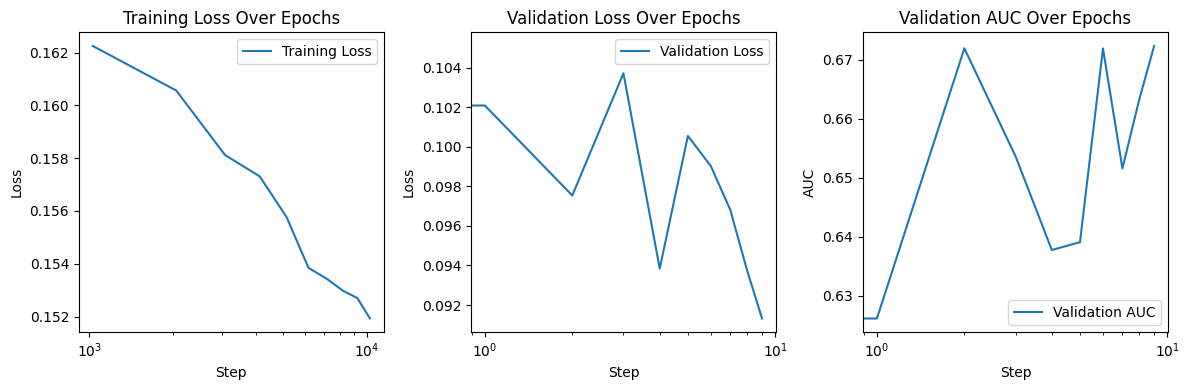

In [ ]:
base_path = 'lightning_logs/gcn_model'
latest_dir = find_latest_directory(base_path)
plot_metrics(latest_dir, 'GCN Model')

### Test graph attention network

In [ ]:
from torch_geometric.nn import GATv2Conv

class GAT(BaseLitModel):
    def __init__(self, input_size, hidden_size, output_size):
        super(GAT, self).__init__(lr=1e-3, weight_decay=0, lr_decay=0.90)
        self.node_network_1 = make_mlp(input_size, [hidden_size]*2, layer_norm=True, hidden_activation="ReLU")
        self.conv = GATv2Conv(hidden_size, hidden_size, heads=1)
        self.node_network_2 = make_mlp(hidden_size, [hidden_size]*2, layer_norm=True, hidden_activation="ReLU")
        self.output_network = make_mlp(hidden_size, [output_size], layer_norm=True, hidden_activation="ReLU", output_activation="Sigmoid")
        self.aggregation = aggr.MeanAggregation()

    def forward(self, graph):
        x = self.node_network_1(graph.x.float())
        x = self.conv(x, graph.edge_index)
        x = self.node_network_2(x)
        x = self.aggregation(x, graph.batch)
        return self.output_network(x)

    def apply_model(self, batch):
        return self(batch), batch.y

# Initialize the model
input_size = train_pyg_loader.dataset[0].x.shape[1]
hidden_size = 64  # You can tune this parameter
output_size = 1
model = GAT(input_size, hidden_size, output_size)

# Train the model
auc_callback = AUCCallback()
csv_logger = CSVLogger('lightning_logs', name='gat_model')  # Initialize CSVLogger
trainer = Trainer(max_epochs=10, accelerator="gpu", callbacks=[auc_callback], logger=csv_logger)  # Add logger to Trainer
trainer.fit(model, train_pyg_loader, valid_pyg_loader)



/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/d/danieltm/.conda/envs/appml/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/gat_model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------------------------------------------------
0 | criterion      | BCELoss         | 0     
1 | node_network_1 | Sequential      | 4.8 K 
2 | conv           | GATv2Conv       | 8.4 K 
3 | node_network_2 | Sequential      | 8.3 K 
4 | output_network | Sequential      | 65    
5 | aggregation    | MeanAggregation | 0     
-----------------------

/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/global/homes/d/danieltm/.conda/envs/appml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 2/1029 [00:00<00:25, 39.79it/s, v_num=0]

Epoch 9: 100%|██████████| 1029/1029 [00:18<00:00, 56.51it/s, v_num=0, val_loss=0.0937, val_auc=0.658, train_loss=0.153]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1029/1029 [00:18<00:00, 56.48it/s, v_num=0, val_loss=0.0937, val_auc=0.658, train_loss=0.153]


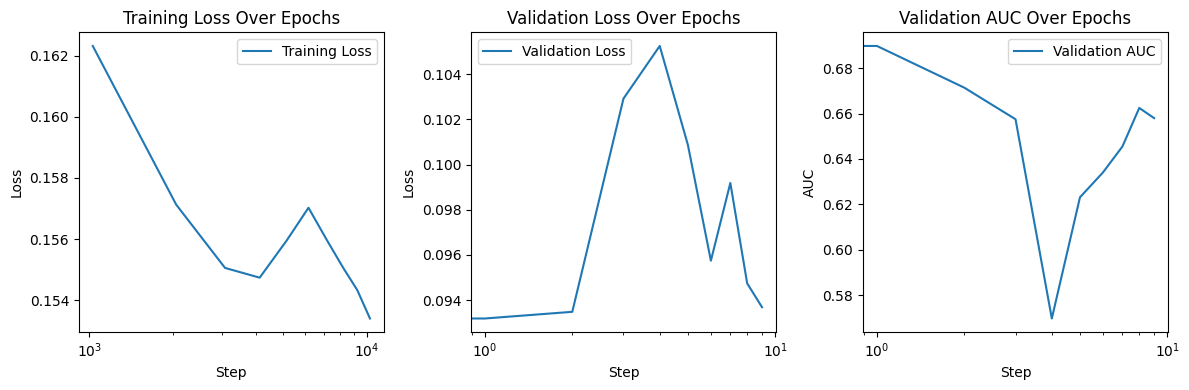

In [ ]:
base_path = 'lightning_logs/gat_model'
latest_dir = find_latest_directory(base_path)
plot_metrics(latest_dir, 'GAT Model')